In [5]:
!conda install -c conda-forge gdcm -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    gdcm-2.8.9                 |   py37h71b2a6d_0         3.4 MB  conda-forge
    libjpeg-turbo-2.0.3        |       h516909a_1        1022 KB  conda-forge
    openssl-1.1.1h             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         6.5 MB

The following NEW packages will be INSTALLED:

  gdcm               conda-forge/linux-64::gdcm-2.8.9-py37h71b2a6d_0
  libjpeg-turbo      conda-forge/linux-64::libjpeg-turbo-2.0.3-h516909a_1

The following packages will be UPDATED:

  openssl                                 1.1.1g-h516909a_1 --> 1.1.1h-h516909a_0



openssl-1.1.1h       | 2.1 MB    | ##################

# !

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import os
import cv2
import random
import pickle
import glob
from pathlib import Path
import gc
from tqdm.notebook import tqdm
from PIL import Image
from tqdm.auto import tqdm
import pydicom
#import gdcm
import multiprocessing as mp

from pydicom.tag import Tag

import scipy.ndimage as ndimage
from scipy.ndimage import zoom
from scipy.stats import kurtosis
from scipy.stats import skew

from sklearn.cluster import KMeans

from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

# !

In [3]:
folder_path = '../input/osic-pulmonary-fibrosis-progression'
train_csv = folder_path + '/train.csv'
test_csv = folder_path+ '/test.csv'
sample_csv = folder_path + '/sample_submission.csv'

train_data = pd.read_csv(train_csv)
test_data = pd.read_csv(test_csv)
sample = pd.read_csv(sample_csv)
train_data.shape

(1549, 7)

In [ ]:
len(train_data["Patient"].unique())

In [ ]:
train_data.isnull().sum()

In [ ]:
dupRows_df = train_data[train_data.duplicated(subset = ['Patient', 'Weeks'], keep = False )]
len(dupRows_df)

# !

In [4]:
train_data.drop_duplicates(subset=['Patient','Weeks'], keep = False, inplace = True)

In [ ]:
pd.unique(train_data[['Sex', 'SmokingStatus']].values.ravel('K'))

In [9]:
dicom_root_path = '../input/osic-pulmonary-fibrosis-progression/test/'
Patients_id = os.listdir(dicom_root_path)
print(len(Patients_id))
n_dicom_dict = {"Patient":[],"n_dicom":[],"list_dicom":[]}

for Patient_id in Patients_id:
    dicom_id_path = glob.glob(dicom_root_path + Patient_id + "/*")
    n_dicom_dict["n_dicom"].append(len(dicom_id_path))
    n_dicom_dict["Patient"].append(Patient_id)
    list_dicom_id = sorted([int(i.split("/")[-1][:-4]) for i in dicom_id_path])
    n_dicom_dict["list_dicom"].append(list_dicom_id)

dicom_pd = pd.DataFrame(n_dicom_dict)
dicom_pd.head()

5


,Patient,n_dicom,list_dicom
0,ID00422637202311677017371,473,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,ID00421637202311550012437,62,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,ID00426637202313170790466,408,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,ID00423637202312137826377,290,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,ID00419637202311204720264,28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


min dicom number is 28
max dicom number is 473


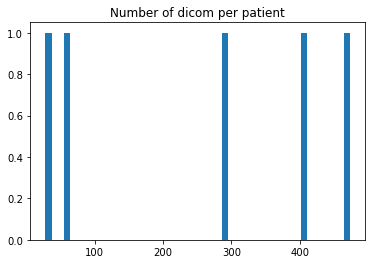

In [10]:
print(f"min dicom number is {min(dicom_pd['n_dicom'])}\n\
max dicom number is {max(dicom_pd['n_dicom'])}")

plt.hist(dicom_pd['n_dicom'], bins=50)
plt.title('Number of dicom per patient');

In [11]:
dicom_pd['height'],dicom_pd['width'] = -1,-1
for Patient_id in Patients_id:
    dicom_id_path = glob.glob(dicom_root_path + Patient_id + "/*")
    for patient_dicom_id_path in dicom_id_path:
        dicom = pydicom.dcmread(patient_dicom_id_path)
        dicom_pd.loc[dicom_pd.Patient==Patient_id,'height'] = dicom.Rows
        dicom_pd.loc[dicom_pd.Patient==Patient_id,'width'] = dicom.Columns
        break

In [12]:
reshape_dicom_pd = dicom_pd.loc[(dicom_pd.height!=512) | (dicom_pd.width!=512),:]
reshape_dicom_pd = reshape_dicom_pd.reset_index(drop=True)
reshape_dicom_pd.head()

,Patient,n_dicom,list_dicom,height,width
0,ID00421637202311550012437,62,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",768,768
1,ID00419637202311204720264,28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1100,888


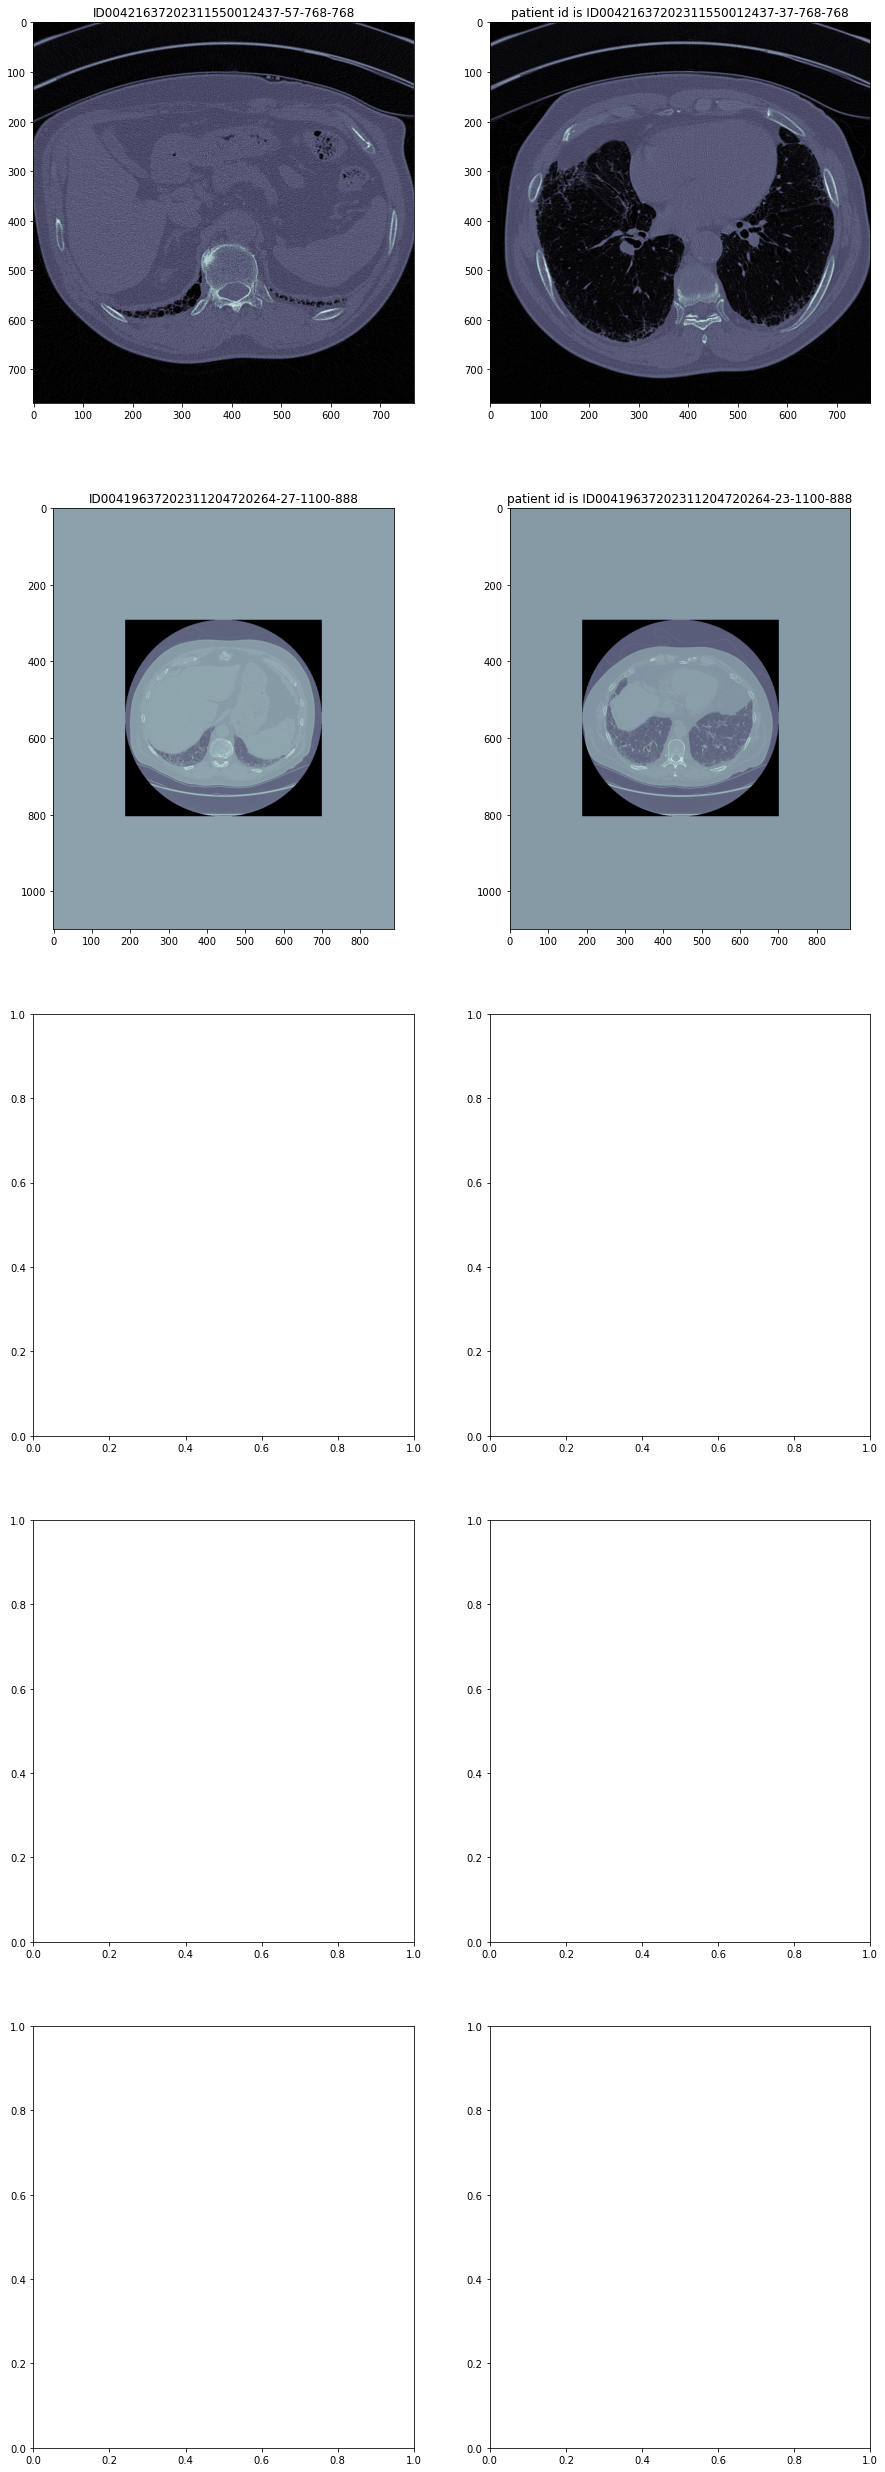

In [13]:
f, ax = plt.subplots(5,2, figsize=(15, 45))
for idx,patient_id in enumerate(reshape_dicom_pd.head()['Patient']):
    paths = random.sample(glob.glob(dicom_root_path + patient_id + "/*"),2)
    dicom1 = pydicom.dcmread(paths[0])
    dicom2 = pydicom.dcmread(paths[1])
    ax[idx,0].set_title(f"{patient_id}-{paths[0].split('/')[-1][:-4]}-{reshape_dicom_pd.loc[idx,'height']}-{reshape_dicom_pd.loc[idx,'width']}")
    ax[idx,0].imshow(dicom1.pixel_array, cmap=plt.cm.bone)
    ax[idx,1].set_title(f"patient id is {patient_id}-{paths[1].split('/')[-1][:-4]}-{reshape_dicom_pd.loc[idx,'height']}-{reshape_dicom_pd.loc[idx,'width']}")
    ax[idx,1].imshow(dicom2.pixel_array, cmap=plt.cm.bone)
plt.show()

In [14]:
crop_id = reshape_dicom_pd[reshape_dicom_pd["height"]!=reshape_dicom_pd["width"]]["Patient"]
reshape_dicom_pd['resize_type'] = 'resize'
reshape_dicom_pd.loc[reshape_dicom_pd.Patient.isin(crop_id),'resize_type'] = 'crop'

In [16]:
dicom_pd['resize_type'] = 'no'
for idx,i in enumerate(reshape_dicom_pd['Patient']):
    dicom_pd.loc[dicom_pd.Patient==i,'resize_type'] = reshape_dicom_pd.loc[idx,'resize_type']
dicom_pd.head()

,Patient,n_dicom,list_dicom,height,width,resize_type
0,ID00422637202311677017371,473,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",512,512,no
1,ID00421637202311550012437,62,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",768,768,resize
2,ID00426637202313170790466,408,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",512,512,no
3,ID00423637202312137826377,290,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",512,512,no
4,ID00419637202311204720264,28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1100,888,crop


In [ ]:
"""
dicom_pd=dicom_pd.merge(train_data,how='right', on=['Patient'])
print(dicom_pd.shape)
print(train_data.shape)
dicom_pd.sample(5)
"""

In [17]:
train_pd = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
temp_pd = pd.DataFrame(columns=train_pd.columns)
for i in range(len(dicom_pd)):
    patient_pd = train_pd[train_pd.Patient==dicom_pd.iloc[i].Patient]
    zeroweek = patient_pd['Weeks'].min()
    if sum(patient_pd.Weeks==zeroweek)>1:
        print(pd.unique(patient_pd.Patient))
    temp_pd = temp_pd.append(patient_pd[patient_pd.Weeks==zeroweek].iloc[0])
dicom_pd = pd.merge(dicom_pd, temp_pd, on=['Patient'])
dicom_pd.shape

(5, 12)

In [18]:
def load_scan(path):
    """
    Loads scans from a folder and into a list.
    
    Parameters: path (Folder path)
    
    Returns: slices (List of slices)
    """
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        except:
            slice_thickness = slices[0].SliceThickness
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [19]:
def transform_to_hu(slices):
    """
    transform dicom.pixel_array to Hounsfield.
    Parameters: list dicoms
    Returns:numpy Hounsfield
    """
    
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    # convert ouside pixel-values to air:
    # I'm using <= -1000 to be sure that other defaults are captured as well
    images[images <= -1000] = 0
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

In [20]:
def generate_internal_mask(image):
    """
    Generates markers for a given image.
    Parameters: image
    Returns: Internal Marker, External Marker, Watershed Marker
    """
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
    marker_internal = marker_internal_labels > 0
    
    return marker_internal

In [21]:
def generate_markers(image):
    """
    Generates markers for a given image.
    Parameters: image
    Returns: Internal Marker, External Marker, Watershed Marker
    """
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
    marker_internal = marker_internal_labels > 0
    
    # Creation of the External Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    
    # Creation of the Watershed Marker
    marker_watershed = np.zeros((image.shape[0], image.shape[1]), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed


In [22]:
def seperate_lungs_Watershed(image, iterations = 1):
    """
    Segments lungs using various techniques.
    
    Parameters: image (Scan image), iterations (more iterations, more accurate mask)
    
    Returns: 
        - Segmented Lung
        - Lung Filter
        - Outline Lung
        - Watershed Lung
        - Sobel Gradient
    """
    
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    
    '''
    Creation of Sobel Gradient
    '''
    
    # Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    
    '''
    Using the watershed algorithm
    
    
    We pass the image convoluted by sobel operator and the watershed marker
    to morphology.watershed and get a matrix matrix labeled using the 
    watershed segmentation algorithm.
    '''
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    
    
    return watershed

In [23]:
def crop_image(img: np.ndarray):
    edge_pixel_value = img[0, 0]
    mask = img != edge_pixel_value
    return img[np.ix_(mask.any(1),mask.any(0))]

def resize_image(img: np.ndarray,reshape=(512,512)):
    img = [cv2.resize(im,(512,512)) for im in img]
    return img

def preprocess_img(img,local_pd):
    #if local_pd.resize_type == 'resize':
    #    img = [resize_image(im) for im in img]
    if local_pd.resize_type == 'crop':
        img = [crop_image(im) for im in img]
    return np.array(img, dtype=np.int16)

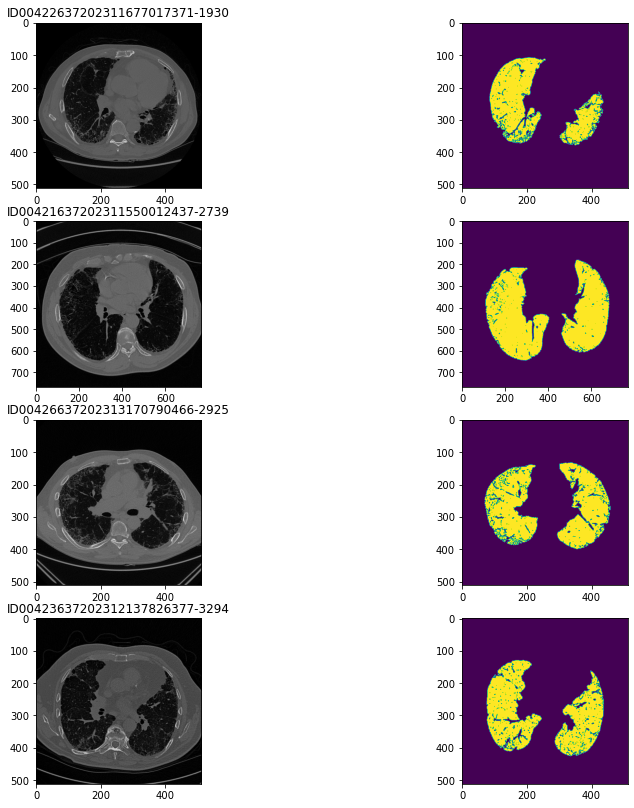

In [24]:
thresh = [-500,0]
f, ax = plt.subplots(4,2, figsize=(14, 14))
for i in range(4):
    path = os.path.join(dicom_root_path,dicom_pd.iloc[i].Patient)
    patient_scans = load_scan(path)
    patient_images = transform_to_hu(patient_scans)
    patient_images = preprocess_img(patient_images,dicom_pd.iloc[i])
    
    num_slices = len(patient_images)
    patient_image = patient_images[num_slices//2]
    
    Mask = generate_internal_mask(patient_image)
    
    ax[i,0].set_title(f"{dicom_pd.iloc[i].Patient}-{dicom_pd.iloc[i].FVC}")
    ax[i,0].imshow(patient_image,cmap='gray')
    ax[i,1].imshow(Mask)
    
plt.show()
plt.close()

IndexError: single positional indexer is out-of-bounds

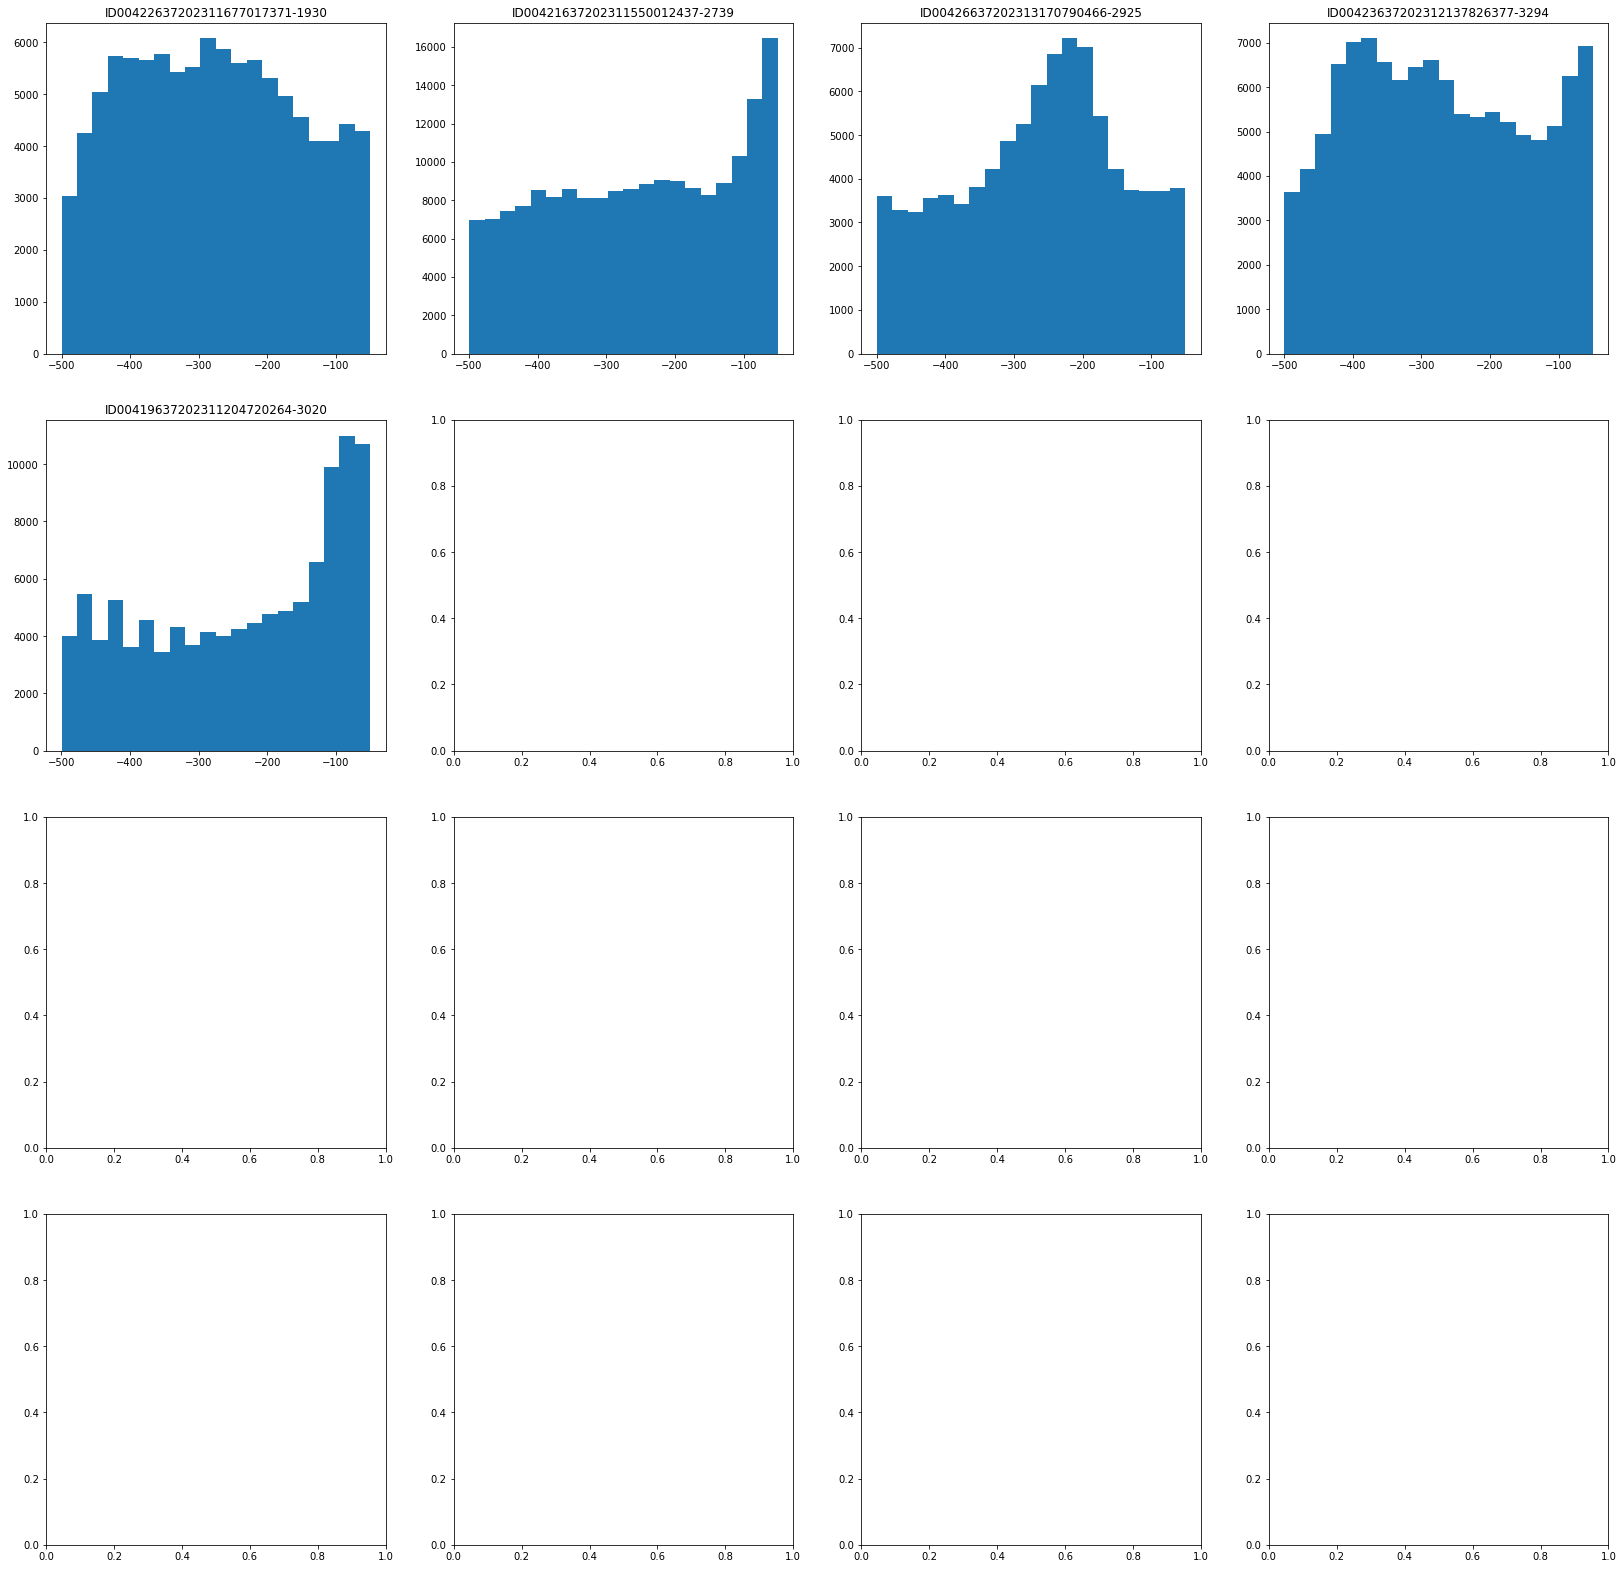

In [25]:
thresh = [-500,-50]
f, ax = plt.subplots(4,4, figsize=(28, 28))
for i in range(16):
    path = os.path.join(dicom_root_path,dicom_pd.iloc[i].Patient)
    patient_scans = load_scan(path)
    patient_images = transform_to_hu(patient_scans)
    patient_images = preprocess_img(patient_images,dicom_pd.iloc[i])
    
    num_slices = len(patient_images)
    patient_images = patient_images[int(num_slices*0.1):int(num_slices*0.9)]
    #patient_images = patient_images[num_slices//2]
    patient_images_mean = np.mean(patient_images,0)
    s_pixel = patient_images_mean.flatten()
    s_pixel = s_pixel[np.where((s_pixel>thresh[0])&(s_pixel<thresh[1]))]
    
    ax[i//4,i%4].set_title(f"{dicom_pd.iloc[i].Patient}-{dicom_pd.iloc[i].FVC}")
    ax[i//4,i%4].hist(s_pixel, bins=20)

plt.show()

In [ ]:
def func_volume(patient_scan,patient_mask):
    pixel_spacing = patient_scan.PixelSpacing
    slice_thickness = patient_scan.SliceThickness
    slice_volume = np.count_nonzero(patient_mask)*pixel_spacing[0]*pixel_spacing[1]*slice_thickness
    return slice_volume

def caculate_lung_volume(patient_scans,patient_images):
    """
    caculate volume of lung from mask
    Parameters: list dicom scans,list patient CT image
    Returns: volume cm³　(float)
    """
    patient_masks = pool.map(generate_internal_mask,patient_images)
    lung_volume = np.array(list(map(func_volume,patient_scans,patient_masks))).sum()

    return lung_volume*0.001

In [ ]:
def caculate_histgram_statistical(patient_images,thresh = [-500,-50]):
    """
    caculate hisgram kurthosis of lung hounsfield
    Parameters: list patient CT image 512*512,thresh divide lung
    Returns: histgram statistical characteristic(Mean,Skew,Kurthosis)
    """
    statistical_characteristic = dict(Mean=0,Skew=0,Kurthosis=0)
    num_slices = len(patient_images)
    patient_images = patient_images[int(num_slices*0.1):int(num_slices*0.9)]
    patient_images_mean = np.mean(patient_images,0)
    
    s_pixel = patient_images_mean.flatten()
    s_pixel = s_pixel[np.where((s_pixel)>thresh[0]&(s_pixel<thresh[1]))]
    
    statistical_characteristic['Mean'] = np.mean(s_pixel)
    statistical_characteristic['Skew'] = skew(s_pixel)
    statistical_characteristic['Kurthosis'] = kurtosis(s_pixel)
    
    return statistical_characteristic

In [ ]:
lung_stat_pd = pd.DataFrame(columns=['Patient','Volume','Mean','Skew','Kurthosis'])
pool = mp.Pool()
for i in tqdm(range(len(dicom_pd))):
    path = os.path.join(dicom_root_path,dicom_pd.iloc[i].Patient)
    lung_stat_pd.loc[i,'Patient'] = dicom_pd.iloc[i].Patient
    patient_scans = load_scan(path)
    patient_images = transform_to_hu(patient_scans)
    patient_images = preprocess_img(patient_images,dicom_pd.iloc[i])
    lung_stat_pd.loc[i,'Volume'] = caculate_lung_volume(patient_scans,patient_images)
                                    
    patient_images = resize_image(patient_images) if dicom_pd.iloc[i].resize_type=='resize' else patient_images
    
    statistical_characteristic = caculate_histgram_statistical(patient_images)
    lung_stat_pd.loc[i,'Mean'] = statistical_characteristic['Mean']
    lung_stat_pd.loc[i,'Skew'] = statistical_characteristic['Skew']
    lung_stat_pd.loc[i,'Kurthosis'] = statistical_characteristic['Kurthosis']

lung_stat_pd.head()

In [ ]:
dicom_feature = pd.merge(dicom_pd, lung_stat_pd, on=['Patient'])
dicom_feature.head()

In [ ]:
dicom_feature.to_csv('CT_feature.csv')

# ! 

In [5]:
dicom_feature = pd.read_csv("../input/ct-featurecsv/CT_feature.csv")
dicom_feature.shape

(176, 17)

# !

In [6]:
dicom_feature = dicom_feature.merge(pd.read_csv("../input/ctfeaturecsv/CT_feature_test.csv"),how="outer")
dicom_feature.shape

(181, 17)

In [33]:
train_data=train_data.merge(dicom_feature[['Patient','Volume','Mean','Skew','Kurthosis']],how="left", on=['Patient'])
print(dicom_feature.shape)
print(train_data.shape)
train_data.head()

(181, 17)
(1578, 11)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Volume,Mean,Skew,Kurthosis
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,2847.19009,124.028553,1.482019,2.590889


In [ ]:
def distribution(feature):
    plt.figure()
    sns.distplot(train_data[feature])
    print("Max value of {} is:  {:.2f} \nMin value of {} is:  {:.2f}\nMean of {} is: {:.2f}\nStandard Deviation of {} is:{:.2f}"\
      .format(feature,train_data[feature].max(),feature,train_data[feature].min(),feature,train_data[feature].mean(),feature,train_data[feature].std()))

In [ ]:
distribution("FVC")

In [ ]:
distribution("Volume")

In [ ]:
distribution("Age")

In [ ]:
plt.figure()
sns.countplot(data=train_data,x='SmokingStatus',hue='Sex');

In [ ]:
def distribution2(feature):
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    for i in train_data.Sex.unique():
        sns.distplot(train_data[train_data['Sex']==i][feature],label=i)
    plt.title(f"Distribution of {feature} based on Sex")
    plt.legend()

    plt.subplot(122)
    for i in train_data.SmokingStatus.unique():
        sns.distplot(train_data[train_data['SmokingStatus']==i][feature],label=i)
    plt.title(f"Distribution of {feature}  based on Smoking Status")
    plt.legend()

In [ ]:
distribution2("FVC")
distribution2("Percent")

In [ ]:
females=train_data[train_data["Sex"]=="Female"]
males=train_data[train_data["Sex"]=="Male"]
scipy.stats.ttest_ind(females["FVC"],males["FVC"], equal_var=False)

In [ ]:
ex_smokers=train_data[train_data["SmokingStatus"]=="Ex-smoker"]
never_smokers=train_data[train_data["SmokingStatus"]=="Never smoked"]
current_smokers=train_data[train_data["SmokingStatus"]=="Currently smokes"]
scipy.stats.f_oneway(ex_smokers["Percent"],never_smokers["Percent"],current_smokers["Percent"])

In [ ]:
scipy.stats.ttest_ind(never_smokers["Percent"],current_smokers["Percent"], equal_var=False)

In [ ]:
scipy.stats.ttest_ind(ex_smokers["Percent"],current_smokers["Percent"], equal_var=False)

In [ ]:
scipy.stats.ttest_ind(never_smokers["Percent"],ex_smokers["Percent"], equal_var=True)

In [ ]:
distribution2("Volume")

In [ ]:
distribution2("Age")

In [ ]:
import plotly.express as px
fig = px.scatter(train_data,x="FVC",y="Age", facet_col="Sex", color="SmokingStatus",width=800, height=400)
fig.show()

In [ ]:
fig = px.scatter(train_data,x="FVC",y="Weeks", facet_col="Sex", color="SmokingStatus", width=800, height=400)
fig.show()

In [ ]:
fig = px.scatter(train_data,x="FVC",y="Volume", facet_col="Sex", color="SmokingStatus", width=800, height=400)
fig.show()

In [ ]:
train_data=pd.get_dummies(train_data,columns=["Sex","SmokingStatus"],drop_first=True)
train_data.sample(5)

In [ ]:
plt.figure()
sns.heatmap(train_data.corr(),annot=True);

# !!!

In [7]:
sample[['Patient','Weeks']] = sample.Patient_Week.str.split("_",expand = True)
sample =  sample[['Patient','Weeks','Confidence', 'Patient_Week']]
sample

,Patient,Weeks,Confidence,Patient_Week
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12
1,ID00421637202311550012437,-12,100,ID00421637202311550012437_-12
2,ID00422637202311677017371,-12,100,ID00422637202311677017371_-12
3,ID00423637202312137826377,-12,100,ID00423637202312137826377_-12
4,ID00426637202313170790466,-12,100,ID00426637202313170790466_-12
...,...,...,...,...
725,ID00419637202311204720264,133,100,ID00419637202311204720264_133
726,ID00421637202311550012437,133,100,ID00421637202311550012437_133
727,ID00422637202311677017371,133,100,ID00422637202311677017371_133
728,ID00423637202312137826377,133,100,ID00423637202312137826377_133


In [8]:
sample = sample.merge(test_data.drop('Weeks', axis = 1), on = "Patient")

In [9]:
train_data['Source'] = 'train'
sample['Source'] = 'test'

data_df = train_data.append([sample])
data_df.sample(5)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Source,Confidence,Patient_Week
1019,ID00276637202271694539978,31,2738,76.797936,77,Male,Ex-smoker,train,NaN,NaN
575,ID00423637202312137826377,125,3294,79.258903,72,Male,Ex-smoker,test,100.0,ID00423637202312137826377_125
256,ID00075637202198610425520,33,1615,65.991092,52,Female,Never smoked,train,NaN,NaN
549,ID00423637202312137826377,99,3294,79.258903,72,Male,Ex-smoker,test,100.0,ID00423637202312137826377_99
909,ID00234637202261078001846,29,1848,51.038445,66,Male,Ex-smoker,train,NaN,NaN


In [10]:
data_df=data_df.merge(dicom_feature[['Patient','Volume','Mean','Skew','Kurthosis']],how="left", on=['Patient'])
print(dicom_feature.shape)
print(data_df.shape)
data_df.sample(5)

(181, 17)
(3038, 14)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Source,Confidence,Patient_Week,Volume,Mean,Skew,Kurthosis
448,ID00123637202217151272140,85,1484,51.326393,69,Female,Never smoked,train,NaN,NaN,1711.797000,72.896561,1.488252,2.088921
2747,ID00426637202313170790466,-12,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_-12,3684.040076,81.215809,1.430486,1.530936
867,ID00229637202260254240583,28,3402,76.107383,71,Male,Ex-smoker,train,NaN,NaN,4482.140697,78.074812,2.211580,6.508371
2615,ID00423637202312137826377,68,3294,79.258903,72,Male,Ex-smoker,test,100.0,ID00423637202312137826377_68,3290.185919,82.746274,3.692260,17.112597
637,ID00169637202238024117706,16,2474,104.502830,66,Female,Never smoked,train,NaN,NaN,4616.741979,92.491482,1.079649,0.537049


In [11]:
data_df=pd.get_dummies(data_df,columns=["Sex","SmokingStatus"])
data_df.reset_index(inplace = True)
data_df.sample(5)

,index,Patient,Weeks,FVC,Percent,Age,Source,Confidence,Patient_Week,Volume,Mean,Skew,Kurthosis,Sex_Female,Sex_Male,SmokingStatus_Currently smokes,SmokingStatus_Ex-smoker,SmokingStatus_Never smoked
1530,1530,ID00422637202311677017371,13,1955,77.665660,73,train,NaN,NaN,2409.800829,85.603671,1.276419,0.999685,0,1,0,1,0
228,228,ID00068637202190879923934,35,2459,72.725660,73,train,NaN,NaN,3464.397583,69.930777,1.983414,5.884071,0,1,0,1,0
2198,2198,ID00422637202311677017371,6,1930,76.672493,73,test,100.0,ID00422637202311677017371_6,2409.800829,85.603671,1.276419,0.999685,0,1,0,1,0
1651,1651,ID00419637202311204720264,24,3020,70.186855,73,test,100.0,ID00419637202311204720264_24,5553.877354,93.169759,2.810130,15.489320,0,1,0,1,0
1616,1616,ID00419637202311204720264,7,3020,70.186855,73,test,100.0,ID00419637202311204720264_7,5553.877354,93.169759,2.810130,15.489320,0,1,0,1,0


In [12]:
def get_baseline_week(df):
    # make a copy to not change original df    
    _df = df.copy()
    # ensure all Weeks values are INT and not accidentaly saved as string
    _df['Weeks'] = _df['Weeks'].astype(int)
    # as test data is containing all weeks, 
    _df.loc[_df.Source == 'test','min_week'] = np.nan
    _df["min_week"] = _df.groupby('Patient')['Weeks'].transform('min')
    _df['baselined_week'] = _df['Weeks'] - _df['min_week']
    
    return _df 

data_df = get_baseline_week(data_df)
data_df.head()

,index,Patient,Weeks,FVC,Percent,Age,Source,Confidence,Patient_Week,Volume,Mean,Skew,Kurthosis,Sex_Female,Sex_Male,SmokingStatus_Currently smokes,SmokingStatus_Ex-smoker,SmokingStatus_Never smoked,min_week,baselined_week
0,0,ID00007637202177411956430,-4,2315,58.253649,79,train,NaN,NaN,2847.19009,124.028553,1.482019,2.590889,0,1,0,1,0,-4,0
1,1,ID00007637202177411956430,5,2214,55.712129,79,train,NaN,NaN,2847.19009,124.028553,1.482019,2.590889,0,1,0,1,0,-4,9
2,2,ID00007637202177411956430,7,2061,51.862104,79,train,NaN,NaN,2847.19009,124.028553,1.482019,2.590889,0,1,0,1,0,-4,11
3,3,ID00007637202177411956430,9,2144,53.950679,79,train,NaN,NaN,2847.19009,124.028553,1.482019,2.590889,0,1,0,1,0,-4,13
4,4,ID00007637202177411956430,11,2069,52.063412,79,train,NaN,NaN,2847.19009,124.028553,1.482019,2.590889,0,1,0,1,0,-4,15


In [13]:
def get_baseline_FVC(df):
    _df = df.copy()
    base = _df.loc[_df.Weeks == _df.min_week]
    base = base[['Patient','FVC']].copy()
    base.columns = ['Patient','base_FVC']
    
    # add a row which contains the cumulated sum of rows for each patient
    base['nb'] = 1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    
    # drop all except the first row for each patient (= unique rows!), containing the min_week
    base = base[base.nb == 1]
    base.drop('nb', axis = 1, inplace = True)
    
    # merge the rows containing the base_FVC on the original _df
    _df = _df.merge(base, on = 'Patient', how = 'left')    
    _df.drop(['min_week'], axis = 1)
    
    return _df

data_df = get_baseline_FVC(data_df)
data_df.head()

,index,Patient,Weeks,FVC,Percent,Age,Source,Confidence,Patient_Week,Volume,...,Skew,Kurthosis,Sex_Female,Sex_Male,SmokingStatus_Currently smokes,SmokingStatus_Ex-smoker,SmokingStatus_Never smoked,min_week,baselined_week,base_FVC
0,0,ID00007637202177411956430,-4,2315,58.253649,79,train,NaN,NaN,2847.19009,...,1.482019,2.590889,0,1,0,1,0,-4,0,2315
1,1,ID00007637202177411956430,5,2214,55.712129,79,train,NaN,NaN,2847.19009,...,1.482019,2.590889,0,1,0,1,0,-4,9,2315
2,2,ID00007637202177411956430,7,2061,51.862104,79,train,NaN,NaN,2847.19009,...,1.482019,2.590889,0,1,0,1,0,-4,11,2315
3,3,ID00007637202177411956430,9,2144,53.950679,79,train,NaN,NaN,2847.19009,...,1.482019,2.590889,0,1,0,1,0,-4,13,2315
4,4,ID00007637202177411956430,11,2069,52.063412,79,train,NaN,NaN,2847.19009,...,1.482019,2.590889,0,1,0,1,0,-4,15,2315


In [14]:
def own_MinMaxColumnScaler(df, columns):
    """Adds columns with scaled numeric values to range [0, 1]
    using the formula X_scld = (X - X.min) / (X.max - X.min)"""
    for col in columns:
        new_col_name = col + '_scld'
        col_min = df[col].min()
        col_max = df[col].max()        
        df[new_col_name] = (df[col] - col_min) / ( col_max - col_min )

In [15]:
data_df['Weeks']=data_df['Weeks'].astype(float)
transform_attrs = ['FVC', 'Percent', 'Age', 'Volume', 'Mean','Skew','Kurthosis','Weeks','baselined_week','base_FVC']
own_MinMaxColumnScaler(data_df, transform_attrs)
data_df[data_df.Source != "train"].sample(5)

,index,Patient,Weeks,FVC,Percent,Age,Source,Confidence,Patient_Week,Volume,...,FVC_scld,Percent_scld,Age_scld,Volume_scld,Mean_scld,Skew_scld,Kurthosis_scld,Weeks_scld,baselined_week_scld,base_FVC_scld
2277,2277,ID00422637202311677017371,45.0,1930,76.672493,73,test,100.0,ID00422637202311677017371_45,2409.800829,...,0.197954,0.384612,0.615385,0.247858,0.567924,0.165121,0.022885,0.393103,0.393103,0.169948
2490,2490,ID00423637202312137826377,6.0,3294,79.258903,72,test,100.0,ID00423637202312137826377_6,3290.185919,...,0.442749,0.405425,0.589744,0.338409,0.548321,0.477639,0.115078,0.124138,0.124138,0.423291
2426,2426,ID00422637202311677017371,120.0,1930,76.672493,73,test,100.0,ID00422637202311677017371_120,2409.800829,...,0.197954,0.384612,0.615385,0.247858,0.567924,0.165121,0.022885,0.910345,0.910345,0.169948
2530,2530,ID00423637202312137826377,26.0,3294,79.258903,72,test,100.0,ID00423637202312137826377_26,3290.185919,...,0.442749,0.405425,0.589744,0.338409,0.548321,0.477639,0.115078,0.262069,0.262069,0.423291
2339,2339,ID00422637202311677017371,76.0,1930,76.672493,73,test,100.0,ID00422637202311677017371_76,2409.800829,...,0.197954,0.384612,0.615385,0.247858,0.567924,0.165121,0.022885,0.606897,0.606897,0.169948


In [16]:
# get back original data split
train_df = data_df.loc[data_df.Source == 'train']
sub = data_df.loc[data_df.Source == 'test']

In [17]:
def seed_everything(seed): 
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [18]:
seed_everything(1998)

### Features: choose which features you want to use
# you can exclude and include features by extending this feature list
features_list = ["base_FVC_scld","Weeks_scld","Age_scld","Volume_scld","Mean_scld","Skew_scld","Kurthosis_scld","Sex_Male", "Sex_Female","SmokingStatus_Ex-smoker","SmokingStatus_Never smoked","SmokingStatus_Currently smokes"]

### Basics for training:
EPOCHS = 1500
BATCH_SIZE = 256


### LOSS; set tradeoff btw. Pinball-loss and adding score
_lambda = 0.7 # 0.8 default


### Optimizers
# choose ADAM or SGD
optimizer = 'SGD'

Learning rate schedule: 0.001 to 0.026 to 0.000


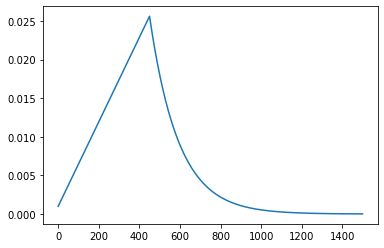

In [19]:
### Learning Rate Scheduler
def get_lr_callback(batch_size = 64, plot = False):
    """Returns a lr_scheduler callback which is used for training.
    Feel free to change the values below!
    """
    LR_START   = 0.001
    LR_MAX     = 0.0001 * BATCH_SIZE # higher batch size --> higher lr
    LR_MIN     = 0.000001
    # 30% of all epochs are used for ramping up the LR and then declining starts
    LR_RAMP_EP = EPOCHS * 0.3
    # how many epochs shall L_RMAX be sustained
    LR_SUS_EP  = 0
    # rate of decay
    LR_DECAY   = 0.993

    def lr_scheduler(epoch):
            if epoch < LR_RAMP_EP:
                lr = (LR_MAX - LR_START) / LR_RAMP_EP * epoch + LR_START

            elif epoch < LR_RAMP_EP + LR_SUS_EP:
                lr = LR_MAX

            else:
                lr = (LR_MAX - LR_MIN) * LR_DECAY ** (epoch - LR_RAMP_EP - LR_SUS_EP) + LR_MIN

            return lr
    
    if plot == False:
        # get the Keras-required callback with our LR for training
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler,verbose = False)
        return lr_callback 
    
    else: 
        return lr_scheduler
    
# plot & check the LR-Scheulder for sanity-check
lr_scheduler_plot = get_lr_callback(batch_size = 64, plot = True)
rng = [i for i in range(EPOCHS)]
y = [lr_scheduler_plot(x) for x in rng]
plt.plot(rng, y)
print(f"Learning rate schedule: {y[0]:.3f} to {max(y):.3f} to {y[-1]:.3f}")


# logging & saving
LOGGING = True

In [20]:
# defining custom callbacks
class LogPrintingCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs = None):
        #print("Training started")
        # self.val_loss = [] not used for now
        self.val_score = []        
        
    def on_epoch_end(self, epoch, logs = None):
        # self.val_loss.append(logs['val_loss']) not used for now
        self.val_score.append(logs['val_score'])
        if epoch % 250 == 0 or epoch == (EPOCHS -1 ):
            print(f"The average val-loss for epoch {epoch} is {logs['val_loss']:.2f}"
                  f" and the val-score is {logs['val_score']}")
            
    def on_train_end(self, lowest_val_loss, logs = None):
        # get index of best epoch
        best_epoch = np.argmin(self.val_score)
        # get score in best epoch
        best_score = self.val_score[best_epoch]
        print(f"Stop training, best model was found and saved in epoch {best_epoch + 1} with val-score: {best_score}."
              f" Final results in this fold (last epoch):") 

In [21]:
def get_checkpont_saver_callback(fold):
    checkpt_saver = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold,
        monitor = 'val_score',
        verbose = 0,
        save_best_only = True,
        save_weights_only = True,
        mode = 'min',
        save_freq = 'epoch')
    
    return checkpt_saver

# Loss Function

In [22]:
# create constants for the loss function
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

# define competition metric
def score(y_true, y_pred):
    """Calculate the competition metric"""
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    sigma_clip = tf.maximum(sigma, C1)
    # Python is automatically broadcasting y_true with shape (1,0) to 
    # shape (3,0) in order to make this subtraction work
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype = tf.float32) )
    metric = (delta / sigma_clip) * sq2 + tf.math.log(sigma_clip * sq2)
    return K.mean(metric)

# define pinball loss
def qloss(y_true, y_pred):
    """Calculate Pinball loss"""
    # IMPORTANT: define quartiles, feel free to change here!
    qs = [0.25, 0.50, 0.75]
    q = tf.constant(np.array([qs]), dtype = tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q * e, (q-1) * e)
    return K.mean(v)

# combine competition metric and pinball loss to a joint loss function
def mloss(_lambda):
    """Combine Score and qloss"""
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda) * score(y_true, y_pred)
    return loss

In [23]:
import tensorflow_addons as tfa

def get_model(optimizer = 'ADAM', lr = 0.01):
    "Creates and returns a model"
    # instantiate optimizer
    optimizer = tf.keras.optimizers.Adam(lr = lr) if optimizer == 'ADAM' else tf.keras.optimizers.SGD()
    
    # create model    
    inp = Layers.Input((len(features_list),), name = "Patient")
    x = Layers.BatchNormalization()(inp)
    x = tfa.layers.WeightNormalization(Layers.Dense(256, activation = "elu", name = "d1"))(x)
    x = Layers.BatchNormalization()(x)
    x = Layers.Dropout(0.3)(x)
    x = tfa.layers.WeightNormalization(Layers.Dense(128, activation = "elu", name = "d2"))(x)
    x = Layers.BatchNormalization()(x)
    x = Layers.Dropout(0.25)(x)
    # predicting the quantiles
    p1 = Layers.Dense(3, activation = "relu", name = "p1")(x)
    # quantile adjusting p1 predictions
    p2 = Layers.Dense(3, activation = "relu", name = "p2")(x)
    
    # adding the cumsum to the output
    # tf.cumsum([a, b, c]) --> [a, a + b, a + b + c]
    preds = Layers.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis = 1), 
                     name = "preds")([p1, p2])
    model = Models.Model(inp, preds, name = "NeuralNet")
    model.compile(loss = mloss(_lambda), optimizer = optimizer, metrics = [score])
    
    return model

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [24]:
neuralNet = get_model(optimizer, lr = 0.01)
neuralNet.summary()

Model: "NeuralNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12)           48          Patient[0][0]                    
__________________________________________________________________________________________________
weight_normalization (WeightNor (None, 256)          6913        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256)          1024        weight_normalization[0][0]       
__________________________________________________________________________________________

In [25]:
## GET TRAINING DATA AND TARGET VALUE

# get target value
y = train_df['FVC'].values.astype(float)


# get training & test data
X_train = train_df[features_list].values
X_test = sub[features_list].values

# instantiate target arrays
train_preds = np.zeros((X_train.shape[0], 3))
test_preds = np.zeros((X_test.shape[0], 3))

In [26]:
## Non-Stratified GroupKFold-split (can be further enhanced with stratification!)
"""K-fold variant with non-overlapping groups.
The same group will not appear in two different folds: in this case we dont want to have overlapping patientIDs in TRAIN and VAL-Data!
The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold."""

NFOLDS = 7
gkf = GroupKFold(n_splits = NFOLDS)
# extract Patient IDs for ensuring 
groups = train_df['Patient'].values

OOF_val_score = []
fold = 0

for train_idx, val_idx in gkf.split(X_train, y, groups = groups):
    fold += 1
    print(f"FOLD {fold}:")
    
    # callbacks: logging & model saving with checkpoints each fold
    # callbacks = [get_lr_callback(BATCH_SIZE)]  # un-comment for using LRScheduler
    reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                          factor = 0.4,
                                                          patience = 150,
                                                          verbose = 1,
                                                        epsilon = 1e-4,
                                                          mode = 'min')
    
    callbacks = [reduce_lr_loss]
    
    if LOGGING == True:
        callbacks +=  [get_checkpont_saver_callback(fold),                     
                     LogPrintingCallback()]

    # build and train model
    model = get_model(optimizer, lr = 0.01)
    history = model.fit(X_train[train_idx], y[train_idx], 
              batch_size = BATCH_SIZE, 
              epochs = EPOCHS, 
              validation_data = (X_train[val_idx], y[val_idx]), 
              callbacks = callbacks,
              verbose = 0) 
    
    # evaluate
    print("Train:", model.evaluate(X_train[train_idx], y[train_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True))
    print("Val:", model.evaluate(X_train[val_idx], y[val_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True))
    
    ## Load best model to make pred
    model.load_weights('fold-%i.h5'%fold)
    train_preds[val_idx] = model.predict(X_train[val_idx],
                                         batch_size = BATCH_SIZE,
                                         verbose = 0)
    
    # append OOF evaluation to calculate OFF_Score
    OOF_val_score.append(model.evaluate(X_train[val_idx], y[val_idx], verbose = 0, batch_size = BATCH_SIZE, return_dict = True)['score'])
    
    # predict on test set and average the predictions over all folds
    print("Predicting Test...")
    test_preds += model.predict(X_test, batch_size = BATCH_SIZE, verbose = 0) / NFOLDS

FOLD 1:
The average val-loss for epoch 0 is 947.55 and the val-score is 24.79812240600586
The average val-loss for epoch 250 is 356.71 and the val-score is 8.225811958312988
The average val-loss for epoch 500 is 66.32 and the val-score is 7.161934852600098

Epoch 00745: ReduceLROnPlateau reducing learning rate to 0.003999999910593033.
The average val-loss for epoch 750 is 54.24 and the val-score is 6.951569557189941

Epoch 00895: ReduceLROnPlateau reducing learning rate to 0.0015999998897314072.
The average val-loss for epoch 1000 is 54.39 and the val-score is 6.957652568817139

Epoch 01045: ReduceLROnPlateau reducing learning rate to 0.0006399999372661114.

Epoch 01195: ReduceLROnPlateau reducing learning rate to 0.0002559999702498317.
The average val-loss for epoch 1250 is 55.51 and the val-score is 6.981732368469238

Epoch 01345: ReduceLROnPlateau reducing learning rate to 0.00010239998809993268.

Epoch 01495: ReduceLROnPlateau reducing learning rate to 4.0959994657896465e-05.
The a

Predicting Test...
FOLD 7:
The average val-loss for epoch 0 is 1002.73 and the val-score is 24.79812240600586
The average val-loss for epoch 250 is 140.34 and the val-score is 7.760445594787598
The average val-loss for epoch 500 is 78.46 and the val-score is 7.202766418457031

Epoch 00728: ReduceLROnPlateau reducing learning rate to 0.003999999910593033.
The average val-loss for epoch 750 is 67.48 and the val-score is 7.107891082763672

Epoch 00878: ReduceLROnPlateau reducing learning rate to 0.0015999998897314072.
The average val-loss for epoch 1000 is 61.33 and the val-score is 7.003926753997803

Epoch 01028: ReduceLROnPlateau reducing learning rate to 0.0006399999372661114.

Epoch 01178: ReduceLROnPlateau reducing learning rate to 0.0002559999702498317.
The average val-loss for epoch 1250 is 61.64 and the val-score is 7.003861427307129

Epoch 01328: ReduceLROnPlateau reducing learning rate to 0.00010239998809993268.

Epoch 01478: ReduceLROnPlateau reducing learning rate to 4.0959994

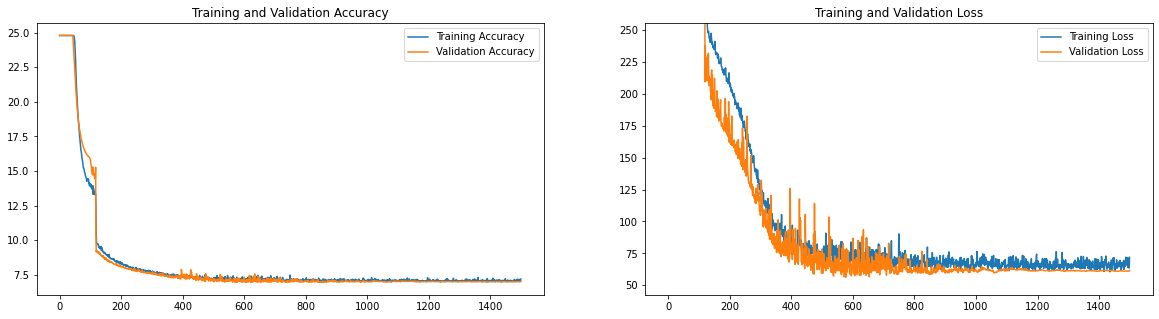

In [27]:
# fetch results from history
score = history.history['score']
val_score = history.history['val_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

# create subplots
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, score, label = 'Training Accuracy')
plt.plot(epochs_range, val_score, label = 'Validation Accuracy')
# limit y-values for better zoom-scale. Remember that roughly -4.5 is the best possible score
# plt.ylim(0.8 * np.mean(val_score), 1.2 * np.mean(val_score))
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
# limit y-values for beter zoom-scale
plt.ylim(0.3 * np.mean(val_loss), 1.8 * np.mean(val_loss))

plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
np.mean(OOF_val_score)
#6.865206718444824 0.7

6.933828694479806

In [29]:
## FIND OPTIMIZED STANDARD-DEVIATION
sigma_opt = mean_absolute_error(y, train_preds[:,1])
sigma_uncertain = train_preds[:,2] - train_preds[:,0]
sigma_mean = np.mean(sigma_uncertain)
print(sigma_opt, sigma_mean)

194.14682877109078 408.4197756787821


In [30]:
sub.head()

,index,Patient,Weeks,FVC,Percent,Age,Source,Confidence,Patient_Week,Volume,...,FVC_scld,Percent_scld,Age_scld,Volume_scld,Mean_scld,Skew_scld,Kurthosis_scld,Weeks_scld,baselined_week_scld,base_FVC_scld
1578,1578,ID00419637202311204720264,-12.0,3020,70.186855,73,test,100.0,ID00419637202311204720264_-12,5553.877354,...,0.393575,0.332421,0.615385,0.571238,0.619832,0.363525,0.10579,0.000000,0.000000,0.3724
1579,1579,ID00419637202311204720264,-12.0,3020,70.186855,73,test,100.0,ID00419637202311204720264_-12,5553.877354,...,0.393575,0.332421,0.615385,0.571238,0.619832,0.363525,0.10579,0.000000,0.000000,0.3724
1580,1580,ID00419637202311204720264,-11.0,3020,70.186855,73,test,100.0,ID00419637202311204720264_-11,5553.877354,...,0.393575,0.332421,0.615385,0.571238,0.619832,0.363525,0.10579,0.006897,0.006897,0.3724
1581,1581,ID00419637202311204720264,-11.0,3020,70.186855,73,test,100.0,ID00419637202311204720264_-11,5553.877354,...,0.393575,0.332421,0.615385,0.571238,0.619832,0.363525,0.10579,0.006897,0.006897,0.3724
1582,1582,ID00419637202311204720264,-10.0,3020,70.186855,73,test,100.0,ID00419637202311204720264_-10,5553.877354,...,0.393575,0.332421,0.615385,0.571238,0.619832,0.363525,0.10579,0.013793,0.013793,0.3724


In [31]:
## PREPARE SUBMISSION FILE WITH OUR PREDICTIONS
sub['FVC1'] = test_preds[:, 1]
sub['Confidence1'] = test_preds[:,2] - test_preds[:,0]

# get rid of unused data and show some non-empty data
submission = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
submission.loc[~submission.FVC1.isnull()].head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Patient_Week,FVC,Confidence,FVC1,Confidence1
1578,ID00419637202311204720264_-12,3020,100.0,2938.150787,353.822327
1579,ID00419637202311204720264_-12,3020,100.0,2938.150787,353.822327
1580,ID00419637202311204720264_-11,3020,100.0,2934.536621,353.493225
1581,ID00419637202311204720264_-11,3020,100.0,2934.536621,353.493225
1582,ID00419637202311204720264_-10,3020,100.0,2930.902802,353.161133
1583,ID00419637202311204720264_-10,3020,100.0,2930.902802,353.161133
1584,ID00419637202311204720264_-9,3020,100.0,2927.246674,352.825104
1585,ID00419637202311204720264_-9,3020,100.0,2927.246674,352.825104
1586,ID00419637202311204720264_-8,3020,100.0,2923.570068,352.486053
1587,ID00419637202311204720264_-8,3020,100.0,2923.570068,352.486053


In [33]:
submission.loc[~submission.FVC1.isnull(),'FVC'] = submission.loc[~submission.FVC1.isnull(),'FVC1']

if sigma_mean < 70:
    submission['Confidence'] = sigma_opt
else:
    submission.loc[~submission.FVC1.isnull(),'Confidence'] = submission.loc[~submission.FVC1.isnull(),'Confidence1']

In [34]:
submission.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1578,ID00419637202311204720264_-12,2938.150787,353.822327,2938.150787,353.822327
1579,ID00419637202311204720264_-12,2938.150787,353.822327,2938.150787,353.822327
1580,ID00419637202311204720264_-11,2934.536621,353.493225,2934.536621,353.493225
1581,ID00419637202311204720264_-11,2934.536621,353.493225,2934.536621,353.493225
1582,ID00419637202311204720264_-10,2930.902802,353.161133,2930.902802,353.161133


In [36]:
submission.drop_duplicates(subset=['Patient_Week'], keep = "first", inplace = True)
submission.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1578,ID00419637202311204720264_-12,2938.150787,353.822327,2938.150787,353.822327
1580,ID00419637202311204720264_-11,2934.536621,353.493225,2934.536621,353.493225
1582,ID00419637202311204720264_-10,2930.902802,353.161133,2930.902802,353.161133
1584,ID00419637202311204720264_-9,2927.246674,352.825104,2927.246674,352.825104
1586,ID00419637202311204720264_-8,2923.570068,352.486053,2923.570068,352.486053


In [37]:
submission.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2559.010685,340.698608,1890.138290,2502.762474,2684.615509,2769.332741,3067.628479
Confidence,730.0,393.654819,161.674019,254.974213,313.158875,335.466431,351.931770,756.418678
FVC1,730.0,2559.010685,340.698608,1890.138290,2502.762474,2684.615509,2769.332741,3067.628479
Confidence1,730.0,393.654819,161.674019,254.974213,313.158875,335.466431,351.931770,756.418678


In [38]:
org_test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

for i in range(len(org_test)):
    submission.loc[submission['Patient_Week']==org_test.Patient[i]+'_'+str(org_test.Weeks[i]), 'FVC'] = org_test.FVC[i]
    submission.loc[submission['Patient_Week']==org_test.Patient[i]+'_'+str(org_test.Weeks[i]), 'Confidence'] = 70

In [ ]:
submission[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index = False)